In [1]:
import pandas as pd
import numpy as np
import torch
import torchsde
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import optuna
import matplotlib.pyplot as plt


dataset_path = r"..\..\datasets\petr4_options_data\processed_petr4_options.csv"
european_calls = pd.read_csv(dataset_path)
european_calls = european_calls[european_calls["type"] == "CALL"]

import ast

# Extract the 'price' value from the 'spot' column
def extract_price(spot_value):
    try:
        parsed = ast.literal_eval(spot_value)  # Parse the string as a dictionary
        return parsed.get("price")  # Extract 'price'
    except (ValueError, SyntaxError, AttributeError):
        return None  # Return None if parsing fails

# Apply extraction
european_calls["spot_price"] = european_calls["spot"].apply(extract_price)

european_calls = european_calls[european_calls["type"] == "CALL"]
european_calls

,symbol,time,spot,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,variação,spot_price
1,PETRK233,2022-11-07T00:00:00.000Z,"{'price': 27.15, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,20.78,EUROPEAN,8,ITM,1.0,0.0,0.0,-0.000557,0.002227,0.0,100.0,20.1345,-0.6455,27.15
2,PETRK233,2022-11-09T00:00:00.000Z,"{'price': 26.9, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,20.50,EUROPEAN,7,ITM,1.0,0.0,0.0,-0.000557,0.001949,0.0,100.0,19.8839,-0.6161,26.90
3,PETRK233,2022-11-04T00:00:00.000Z,"{'price': 28.3, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,21.80,EUROPEAN,10,ITM,1.0,0.0,0.0,-0.000557,0.002784,0.0,100.0,21.2856,-0.5144,28.30
6,PETRK145,2022-11-16T00:00:00.000Z,"{'price': 27.15, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,14.52,12.96,EUROPEAN,2,ITM,1.0,0.0,0.0,-0.001152,0.001152,0.0,100.0,12.6323,-0.3277,27.15
7,PETRK165,2022-11-17T00:00:00.000Z,"{'price': 27.16, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,16.52,10.93,EUROPEAN,1,ITM,1.0,0.0,0.0,-0.001311,0.000655,0.0,100.0,10.6413,-0.2887,27.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9060,PETRK292,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,13.02,13.07,EUROPEAN,5,ITM,1.0,0.0,0.0,-0.001033,0.002582,0.0,100.0,13.9752,0.9052,26.99
9073,PETRL317,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,13.02,13.07,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.001031,0.012891,0.0,100.0,13.9958,0.9258,26.99
9083,PETRL206,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,17.52,8.56,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.001388,0.017346,0.0,100.0,9.5047,0.9447,26.99
9090,PETRL21,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,9.07,16.98,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.000718,0.008980,0.0,100.0,17.9380,0.9580,26.99


In [2]:
data = european_calls
# Stratified split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(data, data['moneyness']):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

# Add Risk-Free Rate (constant for November 2022)
risk_free_rate = 0.1375  # Selic rate for Brazil in November 2022: https://g1.globo.com/economia/noticia/2022/08/03/copom-eleva-selic-para-1375percent-e-juro-basico-da-economia-chega-ao-maior-patamar-em-seis-anos.ghtml
train_data['RISK_FREE_RATE'] = risk_free_rate
test_data['RISK_FREE_RATE'] = risk_free_rate

# Handle outliers in PREMIUM by capping extreme values
price_upper_limit = train_data['premium'].quantile(0.99)
price_lower_limit = train_data['premium'].quantile(0.01)
train_data['premium'] = train_data['premium'].clip(lower=price_lower_limit, upper=price_upper_limit)

# Define features

features = ['rho',
     'theta',
    'gamma',
    'spot_price',
    "strike",
    "days_to_maturity",
    "volatility",
            
]
target = 'premium'

# Drop MONEYNESS_CATEGORY (it is a string)
train_data = train_data.drop(columns=['moneyness'])
test_data = test_data.drop(columns=['moneyness'])

# Scale with RobustScaler;
# Similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.
# https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler
scaler = RobustScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target].values
y_test = test_data[target].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_18504\2570647110.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_18504\2570647110.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_18504\2570647110.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [3]:
# ------------------------- Neural SDE Model ------------------------- #
class TunableNeuralSDE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(TunableNeuralSDE, self).__init__()
        self.activation = activation
        self.f = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, output_dim)
        )
        self.g = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, x):
        drift = self.f(x)
        diffusion = self.g(x)
        return drift, diffusion

# ------------------------- Hyperparameter Tuning ------------------------- #
# Hyperparameter space
hidden_dims = [64, 128, 256]
activations = [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]

# Search over hyperparameters
best_mse = float('inf')
best_params = None

for hidden_dim, activation, lr, batch_size in itertools.product(hidden_dims, activations, learning_rates, batch_sizes):
    # Initialize model
    model = TunableNeuralSDE(input_dim=len(features), hidden_dim=hidden_dim, output_dim=1, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(10):  # Train for fewer epochs to test configurations
        model.train()
        perm = torch.randperm(X_train_tensor.size(0))
        for i in range(0, X_train_tensor.size(0), batch_size):
            idx = perm[i:i + batch_size]
            X_batch = X_train_tensor[idx]
            y_batch = y_train_tensor[idx]

            optimizer.zero_grad()
            drift, diffusion = model(0, X_batch)
            loss = loss_fn(drift.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        drift_test, _ = model(0, X_test_tensor)
        mse = loss_fn(drift_test.squeeze(), y_test_tensor).item()

    # Best config
    if mse < best_mse:
        best_mse = mse
        best_params = {
            'hidden_dim': hidden_dim,
            'activation': activation,
            'learning_rate': lr,
            'batch_size': batch_size,
            'mse': mse
        }

    print(f"Test MSE: {mse:.4f}, Params: {hidden_dim}, {activation}, {lr}, {batch_size}")

# Print best parameters
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Test MSE: 0.1375, Params: 64, ReLU(), 0.001, 32
Test MSE: 0.4383, Params: 64, ReLU(), 0.001, 64
Test MSE: 0.8328, Params: 64, ReLU(), 0.001, 128
Test MSE: 0.4462, Params: 64, ReLU(), 0.0005, 32
Test MSE: 0.9462, Params: 64, ReLU(), 0.0005, 64
Test MSE: 2.9929, Params: 64, ReLU(), 0.0005, 128
Test MSE: 6.3927, Params: 64, ReLU(), 0.0001, 32
Test MSE: 12.4249, Params: 64, ReLU(), 0.0001, 64
Test MSE: 19.5073, Params: 64, ReLU(), 0.0001, 128
Test MSE: 0.0717, Params: 64, LeakyReLU(negative_slope=0.01), 0.001, 32
Test MSE: 0.2981, Params: 64, LeakyReLU(negative_slope=0.01), 0.001, 64
Test MSE: 1.0222, Params: 64, LeakyReLU(negative_slope=0.01), 0.001, 128
Test MSE: 0.4338, Params: 64, LeakyReLU(negative_slope=0.01), 0.0005, 32
Test MSE: 1.0520, Params: 64, LeakyReLU(negative_slope=0.01), 0.0005, 64
Test MSE: 3.6201, Params: 64, LeakyReLU(negative_slope=0.01), 0.0005, 128
Test MSE: 7.4611, Params: 64, LeakyReLU(negative_slope=0.01), 0.0001, 32
Test MSE: 13.5289, Params: 64, LeakyReLU(negati

In [4]:
"""
Best Hyperparameters:
hidden_dim: 256
activation: LeakyReLU(negative_slope=0.01)
learning_rate: 0.001
batch_size: 32
mse: 0.0406746007502079
"""
# Defining now, as it comes in handy :)
def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    percent_error = np.abs((true - predicted) / true) * 100
    pe5 = np.mean(percent_error <= 5) * 100  # Percentage of predictions within 5% error
    pe10 = np.mean(percent_error <= 10) * 100  # Percentage of predictions within 10% error
    pe20 = np.mean(percent_error <= 20) * 100  # Percentage of predictions within 20% error

    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  PE5: {pe5:.2f}%")
    print(f"  PE10: {pe10:.2f}%")
    print(f"  PE20: {pe20:.2f}%")

# MAPE 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

best_model = TunableNeuralSDE(
    input_dim=len(features),
    hidden_dim=256,  # Best hidden_dim
    output_dim=1,
    activation=nn.ELU(alpha=1.0),  # Best activation
)

# Optimizer and loss function
optimizer = optim.Adam(best_model.parameters(), lr=0.001)  # Best learning rate
loss_fn = nn.MSELoss()

# Training setup
n_epochs = 50  # Train for more epochs now
batch_size = 32  # Best batch size
learning_rate_history = []

# Training loop
for epoch in range(n_epochs):
    best_model.train()
    perm = torch.randperm(X_train_tensor.size(0))
    batch_loss = 0

    for i in range(0, X_train_tensor.size(0), batch_size):
        idx = perm[i:i + batch_size]
        X_batch = X_train_tensor[idx]
        y_batch = y_train_tensor[idx]

        optimizer.zero_grad()
        drift, diffusion = best_model(0, X_batch)
        loss = loss_fn(drift.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
    epoch_loss = batch_loss / (X_train_tensor.size(0) // batch_size)
    learning_rate_history.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {batch_loss / (X_train_tensor.size(0) // batch_size):.4f}")

# Evaluation on the test set
best_model.eval()
with torch.no_grad():
    drift_test, _ = best_model(0, X_test_tensor)
    drift_test_np = drift_test.squeeze().numpy()
    y_test_np = y_test_tensor.numpy()

    evaluation = evaluate_model(y_test_np, drift_test_np, "NeuralSDE")
    
print(evaluation)

Epoch 1/50, Loss: 5.1903
Epoch 2/50, Loss: 0.9153
Epoch 3/50, Loss: 0.4872
Epoch 4/50, Loss: 0.3128
Epoch 5/50, Loss: 0.1477
Epoch 6/50, Loss: 0.1038
Epoch 7/50, Loss: 0.0957
Epoch 8/50, Loss: 0.0802
Epoch 9/50, Loss: 0.0914
Epoch 10/50, Loss: 0.0739
Epoch 11/50, Loss: 0.1129
Epoch 12/50, Loss: 0.1041
Epoch 13/50, Loss: 0.0512
Epoch 14/50, Loss: 0.0822
Epoch 15/50, Loss: 0.0782
Epoch 16/50, Loss: 0.0556
Epoch 17/50, Loss: 0.0775
Epoch 18/50, Loss: 0.0542
Epoch 19/50, Loss: 0.0631
Epoch 20/50, Loss: 0.0583
Epoch 21/50, Loss: 0.0612
Epoch 22/50, Loss: 0.0413
Epoch 23/50, Loss: 0.0379
Epoch 24/50, Loss: 0.0553
Epoch 25/50, Loss: 0.0701
Epoch 26/50, Loss: 0.0442
Epoch 27/50, Loss: 0.0398
Epoch 28/50, Loss: 0.0491
Epoch 29/50, Loss: 0.0372
Epoch 30/50, Loss: 0.0372
Epoch 31/50, Loss: 0.0479
Epoch 32/50, Loss: 0.0415
Epoch 33/50, Loss: 0.0490
Epoch 34/50, Loss: 0.0307
Epoch 35/50, Loss: 0.0522
Epoch 36/50, Loss: 0.0428
Epoch 37/50, Loss: 0.0423
Epoch 38/50, Loss: 0.0402
Epoch 39/50, Loss: 0.

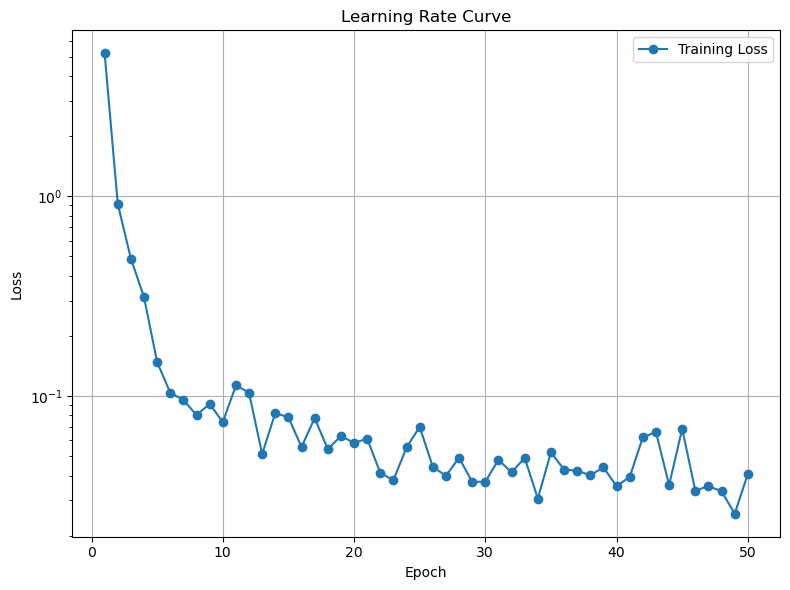

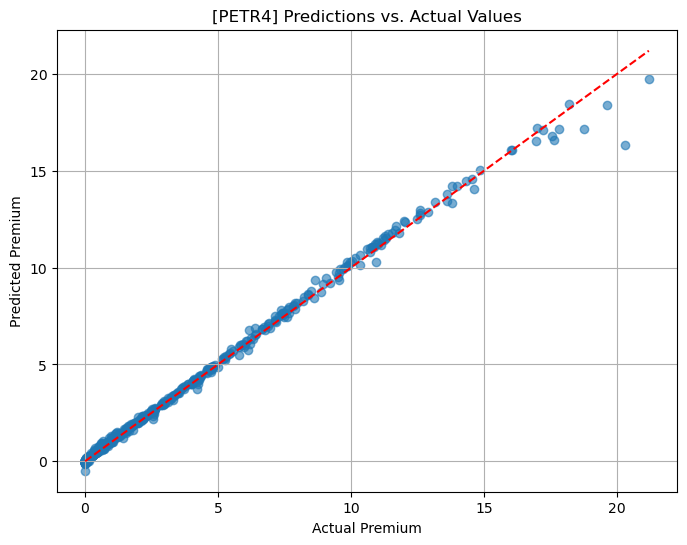

In [5]:
# Predictions vs. actual values

# Plot learning rate (loss reduction) over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_epochs + 1), learning_rate_history, marker='o', label="Training Loss")
plt.title("Learning Rate Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, drift_test.squeeze().numpy(), alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Premium")
plt.ylabel("Predicted Premium")
plt.title("[PETR4] Predictions vs. Actual Values")
plt.grid()
plt.show()


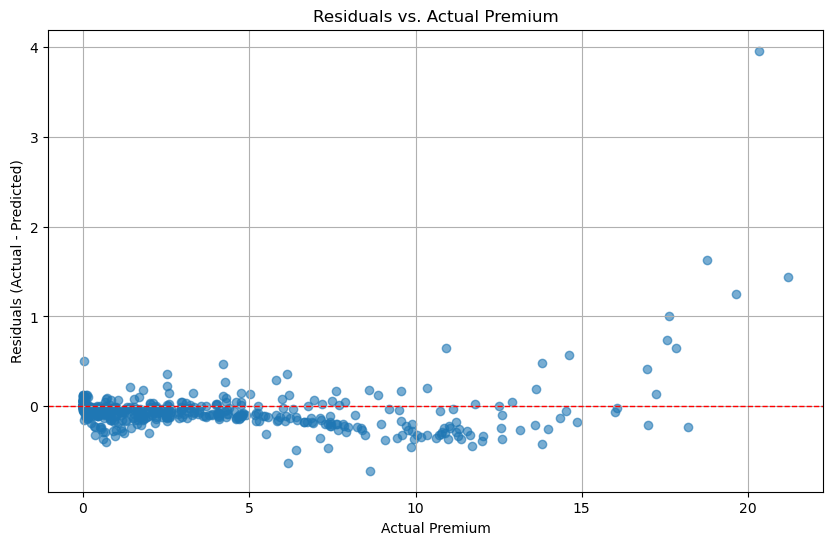

In [6]:
# Assuming y_test and drift_test values are already defined from the earlier folds
actual_values = y_test  # Replace with actual NEGOTIATED_PRICE values
predicted_values = drift_test.squeeze().numpy()  # Replace with predicted values from the best model

# Calculate residuals
residuals = actual_values - predicted_values

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs. Actual Premium")
plt.xlabel("Actual Premium")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid()
plt.show()



In [11]:
data = european_calls

# Being lazy, I don't want to change the entire logic of the code :)
def evaluate_nn(true, predicted):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    percent_error = np.abs((true - predicted) / true) * 100
    pe5 = np.mean(percent_error <= 5) * 100  # Percentage of predictions within 5% error
    pe10 = np.mean(percent_error <= 10) * 100  # Percentage of predictions within 10% error
    pe20 = np.mean(percent_error <= 20) * 100  # Percentage of predictions within 20% error

    
    print(f"\n Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  PE5: {pe5:.2f}%")
    print(f"  PE10: {pe10:.2f}%")
    print(f"  PE20: {pe20:.2f}%")
    
    
itm_options = european_calls[european_calls["moneyness"] == "ITM"]
atm_options = european_calls[european_calls["moneyness"] == "ATM"]
otm_options = european_calls[european_calls["moneyness"] == "OTM"]

# Stratified split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(data, data['moneyness']):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

# Split training data into ITM, ATM, and OTM segments
train_ITM = train_data[train_data['moneyness'] == 'ITM']
train_ATM = train_data[train_data['moneyness'] == 'ATM']
train_OTM = train_data[train_data['moneyness'] == 'OTM']

# Split test data into ITM, ATM, and OTM segments
test_ITM = test_data[test_data['moneyness'] == 'ITM']
test_ATM = test_data[test_data['moneyness'] == 'ATM']
test_OTM = test_data[test_data['moneyness'] == 'OTM']

# Initialize a dictionary to store models for each segment
segment_models = {}
segments = {
    'ITM': (train_ITM, test_ITM),
    'ATM': (train_ATM, test_ATM),
    'OTM': (train_OTM, test_OTM)
}

# Train separate Tunable Neural SDE models for each segment
for segment, (train_segment, test_segment) in segments.items():
    X_train_segment = train_segment[features].values
    y_train_segment = train_segment[target].values
    X_test_segment = test_segment[features].values
    y_test_segment = test_segment[target].values

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train_segment, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_segment, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_segment, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_segment, dtype=torch.float32)

    # Train a Tunable Neural SDE model
    model = TunableNeuralSDE(
        input_dim=len(features),
        hidden_dim=512, 
        output_dim=1,
        activation=nn.ELU(alpha=1.0)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(150):  # Fixed epochs for all segments
        model.train()
        optimizer.zero_grad()
        drift, _ = model(0, X_train_tensor)
        loss = loss_fn(drift.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate and store the model
    model.eval()
    with torch.no_grad():
        drift_test, _ = model(0, X_test_tensor)
        predictions = drift_test.squeeze().numpy()

    metrics = evaluate_nn(y_test_segment, predictions)
    
    segment_models[segment] = {
        'model': model,
        'test_data': (X_test_segment, y_test_segment),
        'predictions': predictions,
        'mse': mse,
        'mape': mape
    }
# Order of output: ITM, ATM, OTM


 Performance:
  MSE: 0.3230917006967725
  MAE: 0.44592701672355906
  R^2: 0.9816824856880951
  PE5: 48.79%
  PE10: 77.78%
  PE20: 96.62%

 Performance:
  MSE: 0.1793161238720286
  MAE: 0.3228637898286184
  R^2: 0.7536785225446601
  PE5: 14.67%
  PE10: 34.67%
  PE20: 62.67%

 Performance:
  MSE: 0.0663827236862571
  MAE: 0.17756014484935223
  R^2: 0.903071119587767
  PE5: 4.95%
  PE10: 8.98%
  PE20: 16.10%


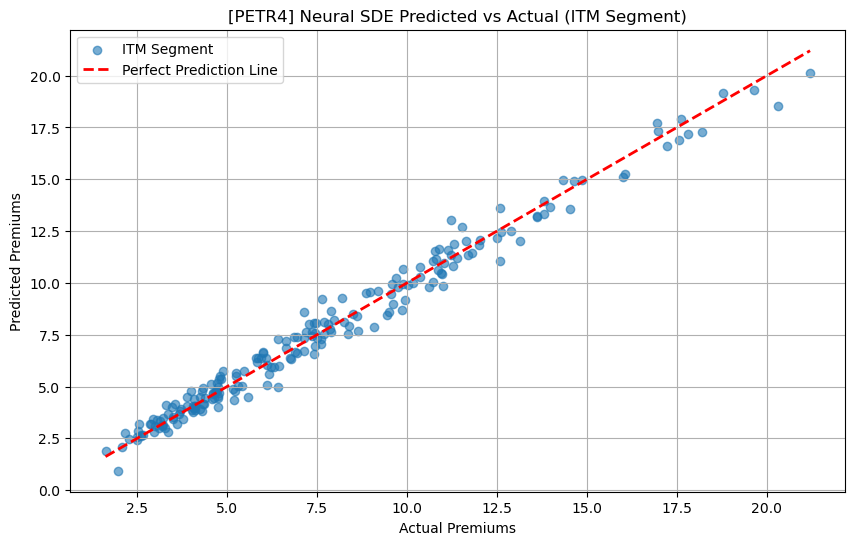

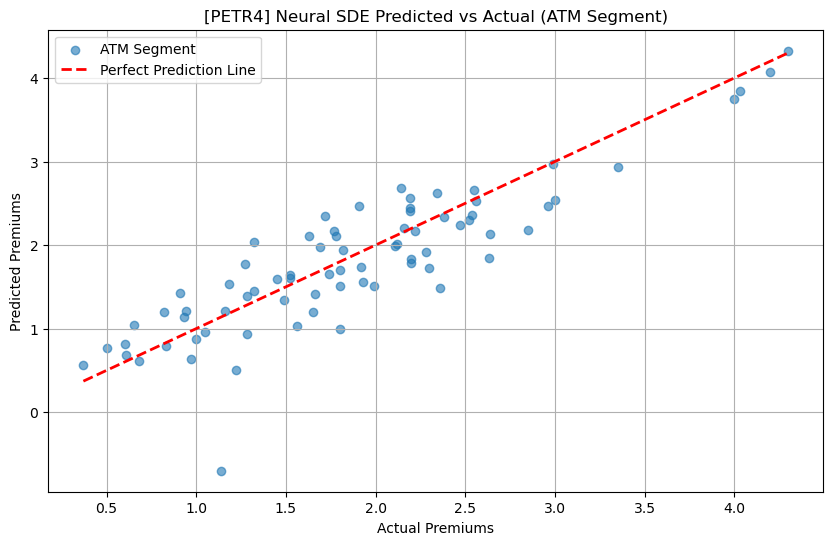

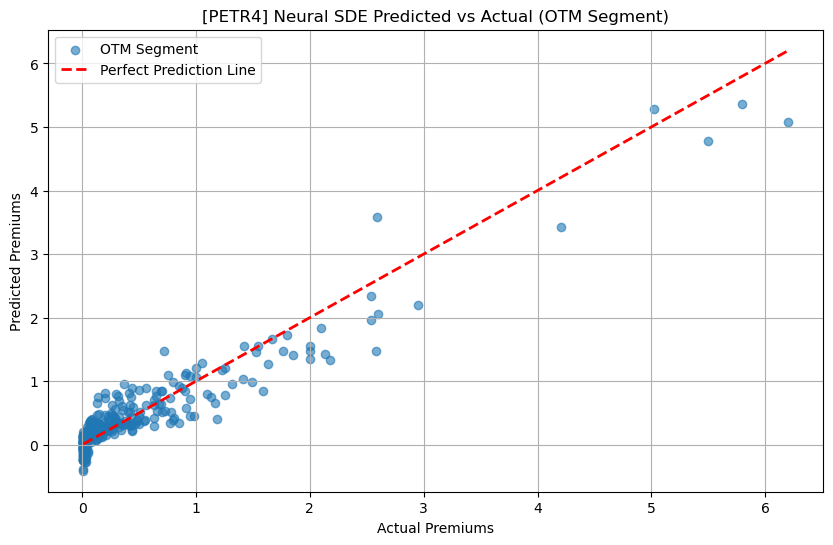

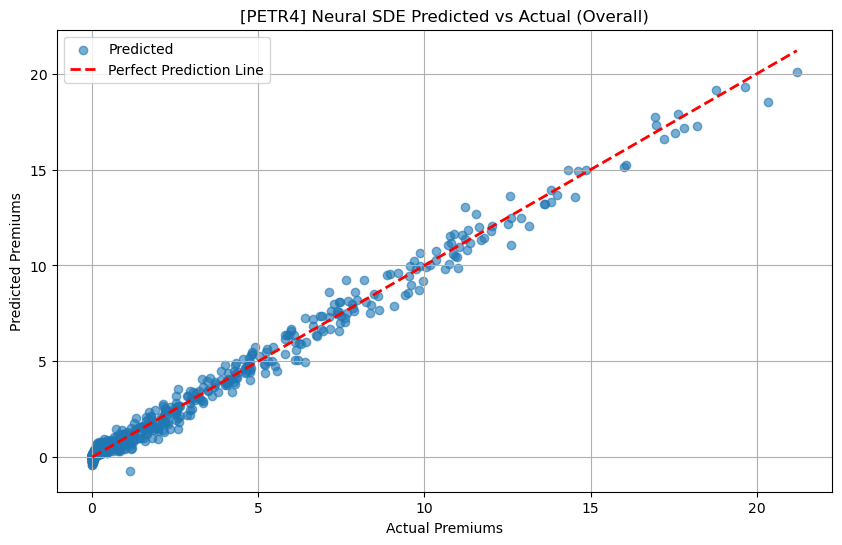

In [12]:
# Predicted vs Actual for each segment
for segment in segments.keys():
    y_test = segment_models[segment]['test_data'][1]  # Actual y_test
    predictions = segment_models[segment]['predictions']  # Predicted values

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.6, label=f'{segment} Segment')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
    plt.title(f"[PETR4] Neural SDE Predicted vs Actual ({segment} Segment)")
    plt.xlabel("Actual Premiums")
    plt.ylabel("Predicted Premiums")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine data for overall comparison
y_test_overall = np.concatenate([segment_models[segment]['test_data'][1] for segment in segments.keys()])
predictions_overall = np.concatenate([segment_models[segment]['predictions'] for segment in segments.keys()])

# Overall dataset visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test_overall, predictions_overall, alpha=0.6, label="Predicted")
plt.plot([y_test_overall.min(), y_test_overall.max()], [y_test_overall.min(), y_test_overall.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("[PETR4] Neural SDE Predicted vs Actual (Overall)")
plt.xlabel("Actual Premiums")
plt.ylabel("Predicted Premiums")
plt.legend()
plt.grid(True)
plt.show()
